## Resnet50 pre-trained model

In order to explore tranfer learning we are going to use a VGG16 model pre-trained with the ImageNet dataset. The model we are going to use are the ones provided by keras. We are not going to used the pre-trained top layers, instead we are going to define our small Fully Connected Network. This FCN is going to be trained to try to use the features calculated by the pre-trained layers with the new dataset of "cats and dogs"

## Common configuration

In [1]:
IMAGE_SIZE = (224,224) # The dimensions to which all images found will be resized.
BATCH_SIZE = 16
NUMBER_EPOCHS = 8

TENSORBOARD_DIRECTORY = "../logs/simple_model/tensorboard"
TRAIN_DIRECTORY = "../data/train/"
VALID_DIRECTORY = "../data/valid/"
WEIGHTS_DIRECTORY = "../weights/"
TEST_DIRECTORY = "../data/test/"

NUMBER_TRAIN_SAMPLES = 20000
NUMBER_VALIDATION_SAMPLES = 5000
NUMBER_TEST_SAMPLES = 2500


Check that we are using the GPU:

In [2]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
    
get_available_gpus()

['/gpu:0']

In [3]:
import tensorflow as tf
# Creates a graph.
with tf.device('/gpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


## Model

### Model definition

In [3]:
from keras.applications.resnet50 import ResNet50
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

Using TensorFlow backend.


### Base Model arquitecture

We have the following model arquitecture:

In [20]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Complete model with FCN Classifier on top

In [4]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# and a logistic layer 
predictions = Dense(2, activation='softmax')(x)

In [5]:
from keras.models import Model
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#### Set the non trainable layers

We are going to set all the vgg16 layers as non trainables:

In [8]:
TRAINABLE_LAST_LAYERS = 0

In [9]:
assert TRAINABLE_LAST_LAYERS >= 0

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
if TRAINABLE_LAST_LAYERS == 0:
    for layer in base_model.layers:
        layer.trainable = False
    print(len(base_model.layers))
else:
    for layer in base_model.layers[:-TRAINABLE_LAST_LAYERS]:
        layer.trainable = False
    print(len(base_model.layers[:-TRAINABLE_LAST_LAYERS]))

19


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [11]:
import pandas as pd
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df

,layer,trainable
0,input_1,False
1,block1_conv1,False
2,block1_conv2,False
3,block1_pool,False
4,block2_conv1,False
5,block2_conv2,False
6,block2_pool,False
7,block3_conv1,False
8,block3_conv2,False
9,block3_conv3,False


## Training the top layer

### Keras callbacks

In [12]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Early stop in case of getting worse
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 0)

#TensorBoard
# run tensorboard with tensorboard --logdir=/full_path_to_your_logs
#tensorboard_path = TENSORBOARD_DIRECTORY
#tensorboard_logger = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=False, write_images=False)
#print('Logging basic info to be used by TensorBoard to {}. To see this log run:'.format(tensorboard_path))
#print('tensorboard --logdir={}'.format(tensorboard_path))

callbacks = [early_stop]#, tensorboard_logger]

### Model optimizer

In [6]:
OPTIMIZER_LEARNING_RATE = 1e-2
OPTIMIZER_DECAY = 1e-4
OPTIMIZER_MOMENTUM = 0.89
OPTIMIZER_NESTEROV_ENABLED = False

In [7]:
from keras.optimizers import SGD

optimizer = SGD(lr=OPTIMIZER_LEARNING_RATE, 
          decay=OPTIMIZER_DECAY, 
          momentum=OPTIMIZER_MOMENTUM, 
          nesterov=OPTIMIZER_NESTEROV_ENABLED)

### Model compilation

In [8]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=["accuracy"])

### Model Training

#### Train data generator

In [16]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_batch_generator =  train_datagen.flow_from_directory(TRAIN_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 17500 images belonging to 2 classes.


#### Validation data generator

In [17]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
validation_datagen = ImageDataGenerator(rescale = 1./255)

valid_batch_generator =  validation_datagen.flow_from_directory(VALID_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 5000 images belonging to 2 classes.


#### Model fitting

In [ ]:
# fine-tune the model
hist = model.fit_generator(
        train_batch_generator,
        steps_per_epoch=NUMBER_TRAIN_SAMPLES/BATCH_SIZE,
        epochs=NUMBER_EPOCHS,  # epochs: Integer, total number of iterations on the data.
        validation_data=valid_batch_generator,
        validation_steps=NUMBER_VALIDATION_SAMPLES/BATCH_SIZE,
        callbacks=callbacks,
        verbose=2)

Epoch 1/8


#### Filenames and labels

Save and load classes and filenames:

In [ ]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_all_classes()

In [ ]:
import pickle

file = PRECOMPUTED_DIRECTORY + '/classes_and_filenames.dat'

# Saving the objects:
with open(file, 'wb') as file:  # Python 2: open(..., 'w')
    pickle.dump([val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames], file)
    

### Keras callbacks

We are going to define two callbacks that are going to be called in the training. EarlyStopping to stop the training if its not getting better. And a tensorboard callback to log information to be used by tensorboard.

In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Early stop in case of getting worse
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 0)

#TensorBoard
# run tensorboard with tensorboard --logdir=/full_path_to_your_logs
tensorboard_path = TENSORBOARD_DIRECTORY
tensorboard_logger = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=False, write_images=False)
print('Logging basic info to be used by TensorBoard to {}. To see this log run:'.format(tensorboard_path))
print('tensorboard --logdir={}'.format(tensorboard_path))

callbacks = [early_stop, tensorboard_logger]

Logging basic info to be used by TensorBoard to ../logs/simple_model/tensorboard. To see this log run:
tensorboard --logdir=../logs/simple_model/tensorboard


### Model Optimizer

In [12]:
OPTIMIZER_LEARNING_RATE = 1e-2
OPTIMIZER_DECAY = 1e-4  # LearningRate = LearningRate * 1/(1 + decay * epoch)
OPTIMIZER_MOMENTUM = 0.89
OPTIMIZER_NESTEROV_ENABLED = False

In [13]:
from keras.optimizers import SGD

optimizer = SGD(lr=OPTIMIZER_LEARNING_RATE, 
          decay=OPTIMIZER_DECAY, 
          momentum=OPTIMIZER_MOMENTUM, 
          nesterov=OPTIMIZER_NESTEROV_ENABLED)

### Compile the model

In [15]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, \
              metrics=["accuracy"])

## Training 

### Train data generator

In [21]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)

train_batch_generator =  train_datagen.flow_from_directory(TRAIN_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 20000 images belonging to 2 classes.


### Validation data generator

In [23]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
validation_datagen = ImageDataGenerator(rescale = 1./255)

valid_batch_generator =  validation_datagen.flow_from_directory(VALID_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 5000 images belonging to 2 classes.


### Model fitting

In [ ]:
# fine-tune the model
hist = model.fit_generator(
        train_batch_generator,
        steps_per_epoch=NUMBER_TRAIN_SAMPLES/BATCH_SIZE,
        epochs=NUMBER_EPOCHS,  # epochs: Integer, total number of iterations on the data.
        validation_data=valid_batch_generator,
        validation_steps=NUMBER_VALIDATION_SAMPLES/BATCH_SIZE,
        callbacks=callbacks,
        verbose=2)

### Training plots

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

## Plot a few examples

## Evaluate the model

In [9]:
############
# load weights
############
model_save_path = WEIGHTS_DIRECTORY + 'resnet50_pretrained_weights.h5'
print("Loading weights from: {}".format(model_save_path))
model.load_weights(model_save_path)

Loading weights from: ../weights/resnet50_pretrained_weights.h5


In [10]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
validation_datagen = ImageDataGenerator(rescale = 1./255)

test_batch_generator =  validation_datagen.flow_from_directory(TEST_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 2500 images belonging to 2 classes.


In [11]:
model.evaluate_generator(test_batch_generator,
                         steps = NUMBER_TEST_SAMPLES/BATCH_SIZE)

[0.044996777125773949, 0.98560000000000003]

## Test the model

In [12]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
test_datagen = ImageDataGenerator(rescale = 1./255)

test_batch_generator = test_datagen.flow_from_directory(
                                TEST_DIRECTORY,
                                target_size = IMAGE_SIZE,
                                batch_size=1,
                                shuffle = False, # Important !!!
                                classes = None,
                                class_mode = None)

Found 2500 images belonging to 2 classes.


In [13]:
test_batch_generator.classes.shape

(2500,)

In [14]:
import pickle
test_classes_file = open("../results/resnet50_true.pickle", "wb" )
pickle.dump( test_batch_generator.classes, test_classes_file )

In [15]:
true_values = test_batch_generator.classes

In [16]:
len(test_batch_generator.filenames)

2500

In [17]:
test_filenames = open("../results/resnet50_filenames.pickle", "wb" )
pickle.dump( test_batch_generator.filenames, test_filenames )

In [18]:
import numpy as np

pred = []

for i in range(int(NUMBER_TEST_SAMPLES)):
    X = next(test_batch_generator)  # get the next batch
    #print(X.shape)
    pred1 = model.predict(X, batch_size = 1, verbose = 0) #predict on a batch
    pred = pred + pred1.tolist()

probabilities = np.array(pred)
print(probabilities.shape)
assert probabilities.shape == (NUMBER_TEST_SAMPLES, 2)

(2500, 2)


In [19]:
test_filenames = open("../results/resnet50_probabilities.pickle", "wb")
pickle.dump( probabilities, test_filenames )

In [20]:
probabilities[0]

array([  9.99993920e-01,   6.13187058e-06])

In [21]:
predictions=np.argmax(probabilities,1)

In [22]:
test_filenames = open("../results/resnet50_predictions.pickle", "wb" )
pickle.dump( predictions, test_filenames )

In [23]:
predictions[0]

0

In [24]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1236   14]
 [  22 1228]]


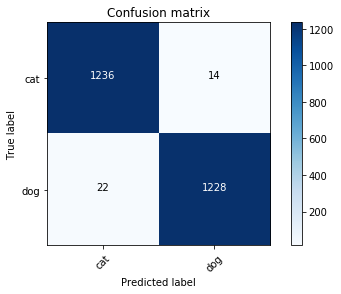

In [25]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['cat', 'dog']
cnf_matrix = confusion_matrix(true_values, predictions)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [26]:
from numpy.random import random, permutation
#1. A few correct labels at random
correct = np.where(predictions==true_values)[0]

idx = permutation(correct)[:4]
#plots_idx(idx, probs[idx])

In [27]:
len(correct)

2464

In [28]:
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt

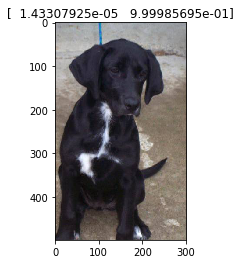

In [30]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[0]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[0]])
plt.show()

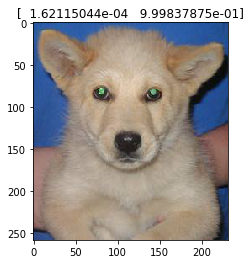

In [31]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[1]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[1]])
plt.show()

In [32]:
from numpy.random import random, permutation
#1. A few correct labels at random
correct = np.where(predictions != true_values)[0]

idx = permutation(correct)[:4]
#plots_idx(idx, probs[idx])

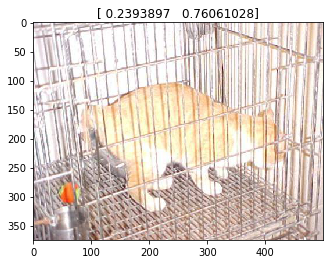

In [33]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[0]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[0]])
plt.show()

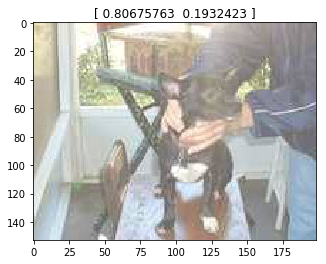

In [34]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[1]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[1]])
plt.show()